# Open and Visualize NetCDF file using Python
In the following Jupyter Notebook, you will find the main steps to open, visualize and manipulate NEMO outputs (for the **GYRE_PISCES** benchmark) in standard <b>NetCDF</b></a> file format, within <b>Python</b>. <br/>

### Step 1. Import Modules

There are several packages available in Python to open and plot a netCDF file. 
Here is a table resuming the main modules used in this notebook: 

| Module name | Description |
| :---: | :---|
| **numpy** | [NumPy](https://numpy.org/) is the fundamental package for scientific computing with Python and for managing ND-arrays |
| **xarray** | [Xarray](http://xarray.pydata.org/en/stable/) introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. |
| **matplotlib** |[Matplotlib](https://matplotlib.org/) is a Python 2D plotting library which produces publication quality figures |
| **cartopy** |[Cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html/) is a library for plotting maps and geospatial data analyses in Python |

An existing and detailed documentation is extremly useful and the use is advised. A lot of good examples using <code>xarray</code> and <code>matplotlib</code> are available and easy to understand. 

In [1]:
import xarray as xr 
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

%matplotlib inline

### Step 2. Load the data of the GYRE_PISCES simulation
Set your own path in variable 'path'!

In [12]:
path = '/data/inputs/nemo/Training2024/Plot/' # SET YOUR OWN PATH TO DATA
dsT = xr.open_mfdataset(path + 'GYRE*grid_T.nc', combine='by_coords') 
dsU = xr.open_mfdataset(path + 'GYRE*grid_U.nc', combine='by_coords')
dsV = xr.open_mfdataset(path + 'GYRE*grid_V.nc', combine='by_coords')

### Get info about the dataset
If instead we prefer to focus on only some specific information, here are some examples: 

- General info on the data:
`dsT.info`
-  Get the list of variables:
`dsT.data_vars`

- Get the list of dimensions:
`dsT.coords`

- Get info on one specific variable (here sosstsst):
`dsT.sosstsst`

- Get info on dimensions:
`dsT.depth, DdsT.time_counter`

In [13]:
dsT.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 31, time_counter: 720, x: 32, y: 22)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(22, 32), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(22, 32), meta=np.ndarray>
  * deptht                (deptht) float32 4.9752655 15.096427 ... 4451.2593
    time_centered         (time_counter) object dask.array<chunksize=(720,), meta=np.ndarray>
  * time_counter          (time_counter) object 0001-01-03 12:00:00 ... 0010-12-28 12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(31, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(720, 2), meta=np.ndarray>
    votemper       

### Step 3. Plot the data 
**Your first 2D maps!**

...sosstsst
...sosaline
...sossheig
...sowaflup
...soshfldo
...sosfldow
...sohefldo
...somxl010
...somixhgt


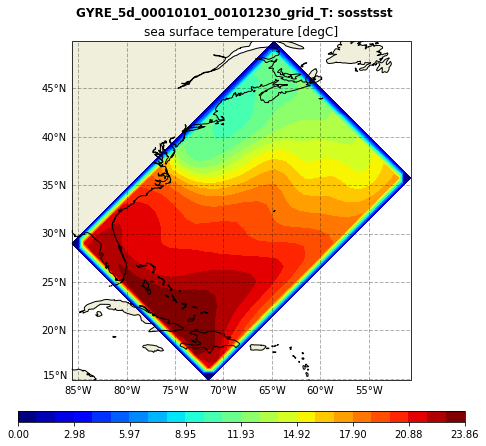

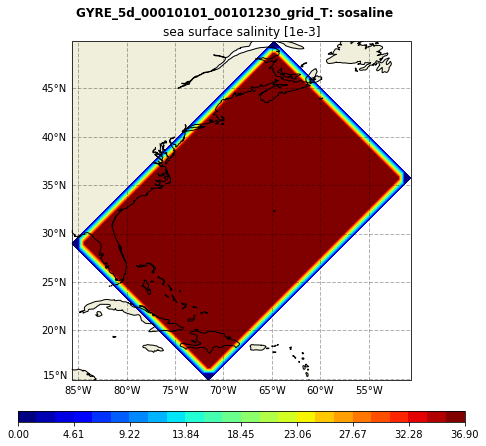

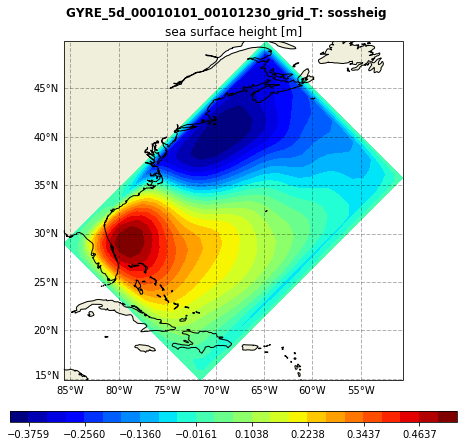

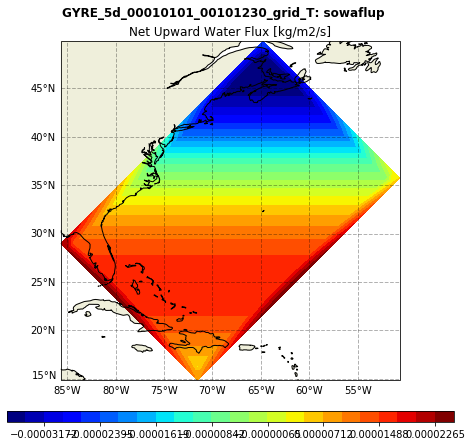

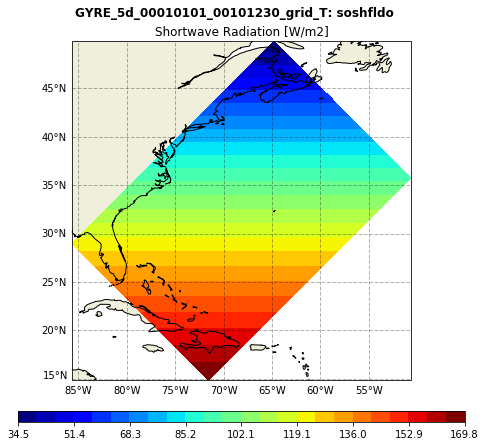

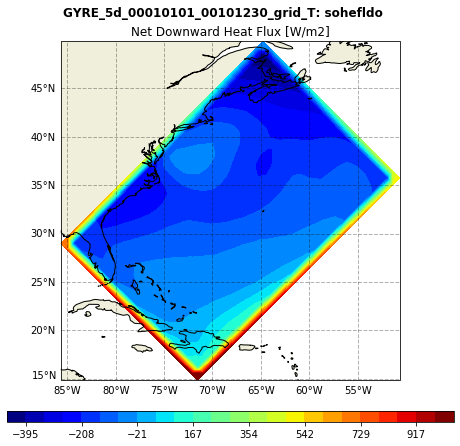

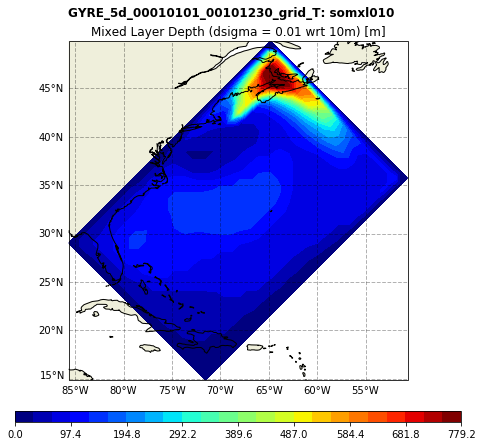

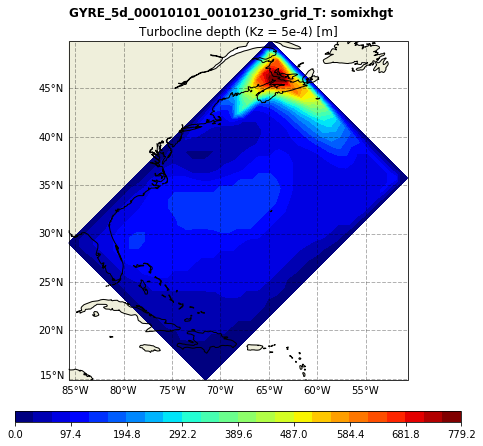

In [27]:
def generate_plot(ds, var, tsp=-1):
    '''This function creates a figure for a given xarray dataset and variable name
    Input arguments: 
    - ds: xarray dataset 
    - var: variable name 
    - tsp: time frame index you want to plot. '-1' valuescorresponds to the last timeframe
    '''
    
    # Find min/max value of the variable 
    vmin = ds[var][tsp,:].min().values
    vmax = ds[var][tsp,:].max().values
    if vmin == vmax: return
    
    levels = np.linspace(vmin,vmax,25, endpoint=True)
    
    # plot 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ds[var][-1,:].plot.contourf(x='nav_lon', y='nav_lat', vmin=vmin, vmax=vmax, levels=levels,\
                                cmap='jet', cbar_kwargs={'aspect':40, 'orientation': 'horizontal', 'pad': 0.07, 'label': ''})
    
    # Customize grid lines
    fig.canvas.draw()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False,
                  linewidth=1, color='k', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    
    # Add title 
    fig.suptitle(ds.name + ': ' + v, y=.94, weight='bold')
    ax.set_title(ds[v].long_name + ' ['+ ds[v].units + ']')
    
    # Save figure
    fig.savefig(v + '.png', dpi=300, bbox_inches='tight')
    return 


# Plot the variables of the 'dsT' dataset/ netcdf files of 'grid_T' 
for v in dsT.variables:
    if len(dsT[v].shape) == 3:
        print('...' + v)
        generate_plot(dsT, v)
        

### Step 4. Compute metrics & save to NetCDF file:  surface Kinetic Energy (KE) 

**Kinetic Energy = 1/2 * (U^2 + V^2)**, where U, V are the ocean current velocities along -i and -j direction respectively.

In [57]:
ds = xr.Dataset(

    {
        "KE": 0.5*(dsU.vozocrtx[:,0,:,:]**2.0 + dsV.vomecrty[:,0,:,:]**2.0),
        "nav_lon": dsU.nav_lon,
        "nav_lat": dsU.nav_lat,
    }
)
# data storage in NetCDF format
nc_file = ds.to_netcdf("./GYRE_5d_KE.nc")

### Compute mean KE & plot

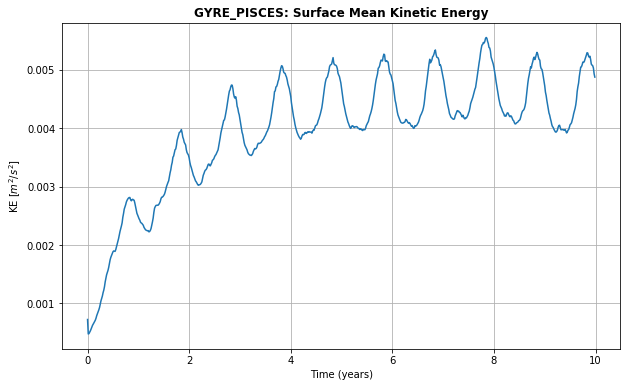

In [59]:
# compute mean KE
KE = ds.KE.mean(['x', 'y']).values

# plot KE
fig, ax = plt.subplots(figsize=(10, 6))

time = np.arange(len(dsT.time_counter)) * 5 / 360 # in years
ax.plot(time, KE)

# Add labels
ax.set_xlabel('Time (years)')
ax.set_ylabel('KE [$m^2/s^2$]')
ax.set_title('GYRE_PISCES: Surface Mean Kinetic Energy', weight='bold')

plt.grid()

### Step 5. Plot Sea Surface Height and Ocean Current vectors 

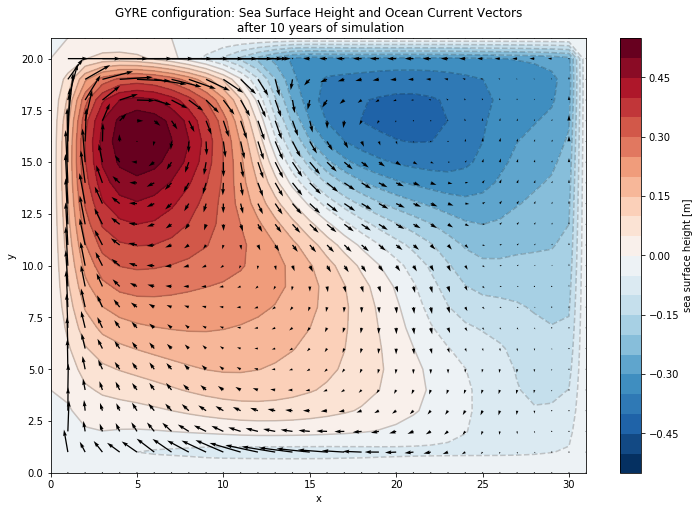

In [60]:
fig = plt.figure(figsize=(12,8))
# plot sea surface height contours at the last time frame
dsT.sossheig[-1,:].plot.contourf(levels=24)
dsT.sossheig[-1,:].plot.contour(colors='k', levels=24 ,alpha=0.2)

# plot ocean current vectors
plt.quiver(dsU.vozocrtx[-1,0,:,:].values, dsV.vomecrty[-1,0,:,:].values, scale=4,units='width')

plt.title('GYRE configuration: Sea Surface Height and Ocean Current Vectors\n after 10 years of simulation')

# save figure
fig.savefig('SSH+Currents1deg.png', dpi=300, bbox_inches='tight')

### Exercise: Try to plot a depth profile for a specific point of the domain. 

**Hint:** In python, the array indexes aranged as [t,z,y,x] or [time,depth,lat,lon]

### Step 7. Calculate statistics

#### Monthly averaging

In [43]:
monthly_avg = dsT.resample(time_counter="1MS").mean()
monthly_avg

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, deptht: 31, time_counter: 120, x: 32, y: 22)
Coordinates:
  * time_counter   (time_counter) object 0001-01-01 00:00:00 ... 0010-12-01 00:00:00
    nav_lon        (y, x) float32 -71.51906 -70.84501 ... -65.45263 -64.77859
    nav_lat        (y, x) float32 14.84501 15.519056 ... 49.221416 49.895462
  * deptht         (deptht) float32 4.9752655 15.096427 ... 4150.2812 4451.2593
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds  (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(1, 31, 2), meta=np.ndarray>
    votemper       (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 31, 22, 32), meta=np.ndarray>
    vosaline       (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 31, 22, 32), meta=np.ndarray>
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(1, 22, 32), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksi

#### Extract timeseries at specific location  

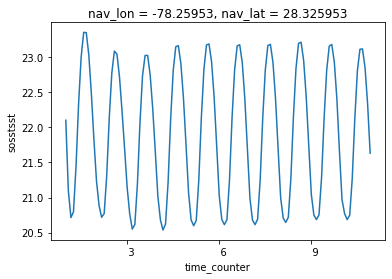

In [44]:
# Remember that in python, the array indexes aranged as [t,z,y,x] or [time,depth,lat,lon]
# e.g. the Sea Surface Temperature
monthly_avg.sosstsst[:,15,5].plot()

**Exercise: What do you notice in the figure above?**

### Calculate monthly anomalies

In climatology, “anomalies” refer to the difference between observations and typical weather for a particular season. Unlike observations, anomalies should not show any seasonal cycle.

In [45]:
dsT

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 31, time_counter: 720, x: 32, y: 22)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(22, 32), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(22, 32), meta=np.ndarray>
  * deptht                (deptht) float32 4.9752655 15.096427 ... 4451.2593
    time_centered         (time_counter) object dask.array<chunksize=(720,), meta=np.ndarray>
  * time_counter          (time_counter) object 0001-01-03 12:00:00 ... 0010-12-28 12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(31, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(720, 2), meta=np.ndarray>
    votemper              (time_counter, deptht, 

/home/gkara/anaconda3/envs/dev/lib/python3.7/site-packages/xarray/core/indexing.py:1325: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


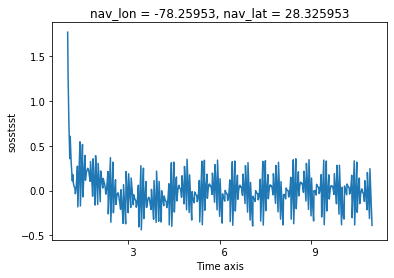

In [46]:
climatology = dsT.groupby("time_counter.month").mean("time_counter")
anomalies = dsT.groupby("time_counter.month") - climatology
#
anomalies.sosstsst[:,15,5].plot()

### Calculating and Plot Seasonal Average maps 

In [49]:
# compute seasonal average for the dataset dsT
dsT_seasonal = dsT.groupby("time_counter.season").mean("time_counter")

Text(0.5, 1.02, 'Seasonal Sea Surface Temperature')

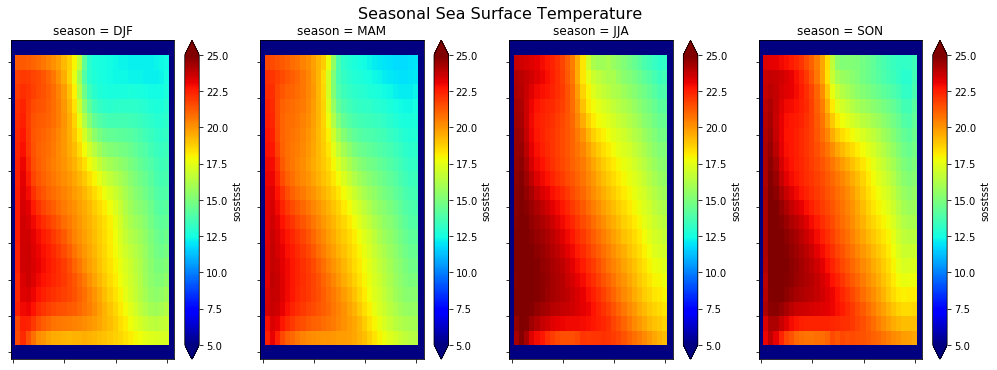

In [52]:
# Quick plot to show the results

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 5))
for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
    dsT_seasonal["sosstsst"].sel(season=season).plot.pcolormesh(
        ax=axes[i],
        vmin=5,
        vmax=25,
        cmap="jet",
        add_colorbar=True,
        extend="both",
    )

    axes[i].set_ylabel(season)
    axes[i].set_ylabel("")
    axes[i].set_ylabel("")

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()

fig.suptitle("Seasonal Sea Surface Temperature", fontsize=16, y=1.02)

### And that's all! Great work! 👏 